In [1]:
#  Copyright 2023 Google LLC
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      https://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.

# Controlled state preparation using rotations

In [2]:
from qualtran.bloqs.state_preparation.state_preparation_via_rotation import StatePreparationViaRotations
from qualtran.drawing import show_bloq
from qualtran import BloqBuilder
from qualtran.bloqs.basic_gates import ZeroState, OneState, OneEffect, PlusState, CNOT
from qualtran.bloqs.rotations.phase_gradient import PhaseGradientState
import numpy as np
import random

This bloq prepares a state $|\psi\rangle$ given a list of its coefficients controlled by another qubit. It uses phase kickback on a gradient state register to perform the rotations, so such state must be provided. It can be obtained from `PhaseGradientState`.

Refer to https://arxiv.org/abs/1812.00954 page 3 for more details on state preparation using rotations.

## Example of use

Assume one wants to implement an arbitrary state whose coefficients are stored in `state_coefs` with `state_bitsizes` sites using a resolution for the rotations of `phase_bitsizes` qubits.

In [3]:
def gen_random_state (state_bitsizes: int):
    state = np.array([random.uniform(-1,1) + random.uniform(-1,1)*1j for _ in range(2**state_bitsizes)])
    return state/np.linalg.norm(state)


random.seed(137)
phase_bitsize = 4
state_bitsize = 3
state_coefs = gen_random_state(state_bitsize)

## Building the bloq

The parameters that the bloq receives are:

  - `phase_bitsize`: number of qubits used to store the rotation angle. This determines the accuracy of the results, but increases computational resources.
  - `state_coefficients`: tuple that contains the coefficients of the quantum state to be encoded, must be of length a power of two.
  - `uncompute`: boolean flag to implement the adjoint of the gate.
  - `control_bitsize`: number of qubits of the control register. Set to zero (default value) for an uncontrolled gate.

Below the bloq and its decomposition are shown. It is possible to see three big bloqs that do the sequential rotations to prepare the amplitude for each of the three qubits and a final bloq to encode the phases of the state.

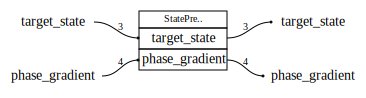

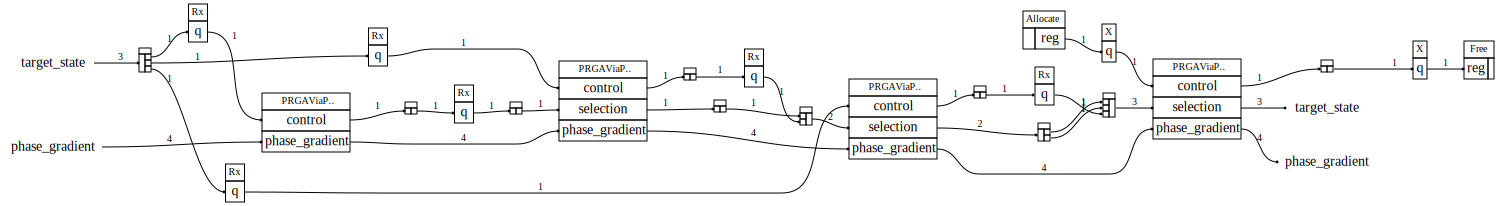

In [4]:
qsp = StatePreparationViaRotations(
    phase_bitsize=phase_bitsize, state_coefficients=tuple(state_coefs)
)
show_bloq(qsp)
show_bloq(qsp.decompose_bloq())

## Using the bloq in a circuit

Now let us show an example of this bloq being used to encode a state, together with the tensor contract to ensure that the coefficients are correctly prepared.

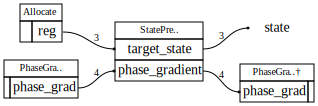

In [5]:
bb = BloqBuilder()
state = bb.allocate(state_bitsize)
phase_gradient = bb.add(PhaseGradientState(phase_bitsize))
state, phase_gradient = bb.add(
    qsp, target_state=state, phase_gradient=phase_gradient
)
bb.add(PhaseGradientState(bitsize=phase_bitsize).adjoint(), phase_grad=phase_gradient)
circuit = bb.finalize(state=state)

show_bloq(circuit)
coefficients = circuit.tensor_contract()

And finally a comparison of the results obtained with the original state used.

In [6]:
accuracy = np.dot(coefficients, np.array(state_coefs).conj())

print(f"original state used: {tuple(state_coefs)}")
print(f"circuit result:      {tuple(coefficients)}\n")
print(f"accuracy: {abs(accuracy)}\n")

print("Comparison (coefficients in polar form):")
for i, (c, s) in enumerate(zip(coefficients, state_coefs)):
    print(f"  |{i:0{state_bitsize}b}> result: {round(abs(c),4)} ∠{round(np.angle(c, deg=True),2)}º  "+\
          f"exact: {round(abs(s),4)} ∠{round(np.angle(s, deg=True),2)}º")

original state used: ((-0.325154454802624-0.06835988570454705j), (0.3727690481439383-0.20459538946824193j), (-0.11498322647057131+0.24380467658161795j), (0.3040205153551564+0.01150305427627897j), (0.351123159456379+0.2580768814763988j), (0.01936319964483079-0.2765842912553688j), (-0.05537014356840069+0.013923970172521885j), (-0.37859710260069473-0.36083564655504496j))
circuit result:      ((-0.30177669529663664-0.12499999999999971j), (0.4516407412190937-0.1870757203331861j), (-0.15432914190872737+0.23096988312782152j), (0.27244755338790905+0.0541931878311847j), (0.3456708580912722+0.2309698831278214j), (0.05419318783118471-0.27244755338790905j), (-0.09567085809127232+0.01903011687217839j), (-0.4077465784244582-0.27244755338790905j))

accuracy: 0.9867557701097965

Comparison (coefficients in polar form):
  |000> result: 0.3266 ∠-157.5º  exact: 0.3323 ∠-168.13º
  |001> result: 0.4889 ∠-22.5º  exact: 0.4252 ∠-28.76º
  |010> result: 0.2778 ∠123.75º  exact: 0.2696 ∠115.25º
  |011> result: 0

## Controlled state preparation

Below is an example of the same state preparation gate but in this case with a two qubit control register that is in the $|+\rangle$ state. Thus, the result of applying the gate $U$, which prepares the state $|\psi\rangle$ is

$$
\frac{1}{\sqrt{2}}U(|0,0\rangle + |1,0\rangle) = \frac{1}{\sqrt{2}}(|0,0\rangle + |1,\psi\rangle)
$$

In [7]:
qsp_ctrl = StatePreparationViaRotations(
    phase_bitsize=phase_bitsize,
    state_coefficients=tuple(state_coefs),
    control_bitsize=1
)
bb = BloqBuilder()
control = bb.add(PlusState())
state = bb.allocate(state_bitsize)
phase_gradient = bb.add(PhaseGradientState(phase_bitsize))
control, state, phase_gradient = bb.add(
    qsp_ctrl, prepare_control=control, target_state=state, phase_gradient=phase_gradient
)
bb.add(PhaseGradientState(bitsize=phase_bitsize).adjoint(), phase_grad=phase_gradient)
network = bb.finalize(control=control, state=state)
coefficients = network.tensor_contract()
correct = 1 / np.sqrt(2) * np.array([1] + [0] * (2**state_bitsize - 1) + list(state_coefs))

And again, a comparison with the desired result

In [8]:
accuracy = np.dot(coefficients, np.array(correct).conj())

print(f"accuracy: {abs(accuracy)}\n")

print("Comparison (coefficients in polar form):")
for i, (c, s) in enumerate(zip(coefficients, correct)):
    print(f"  |{f'{i:0{state_bitsize+1}b}'[0]},{f'{i:0{state_bitsize+1}b}'[1:]}> result: {round(abs(c),4)} ∠{round(np.angle(c, deg=True),2)}º  "+\
          f"exact: {round(abs(s),4)} ∠{round(np.angle(s, deg=True),2)}º")

accuracy: 0.9932982164940862

Comparison (coefficients in polar form):
  |0,000> result: 0.7071 ∠0.0º  exact: 0.7071 ∠0.0º
  |0,001> result: 0.0 ∠90.0º  exact: 0.0 ∠0.0º
  |0,010> result: 0.0 ∠90.0º  exact: 0.0 ∠0.0º
  |0,011> result: 0.0 ∠180.0º  exact: 0.0 ∠0.0º
  |0,100> result: 0.0 ∠90.0º  exact: 0.0 ∠0.0º
  |0,101> result: 0.0 ∠0.0º  exact: 0.0 ∠0.0º
  |0,110> result: 0.0 ∠-180.0º  exact: 0.0 ∠0.0º
  |0,111> result: 0.0 ∠-90.0º  exact: 0.0 ∠0.0º
  |1,000> result: 0.231 ∠-157.5º  exact: 0.2349 ∠-168.13º
  |1,001> result: 0.3457 ∠-22.5º  exact: 0.3007 ∠-28.76º
  |1,010> result: 0.1964 ∠123.75º  exact: 0.1906 ∠115.25º
  |1,011> result: 0.1964 ∠11.25º  exact: 0.2151 ∠2.17º
  |1,100> result: 0.294 ∠33.75º  exact: 0.3081 ∠36.32º
  |1,101> result: 0.1964 ∠-78.75º  exact: 0.1961 ∠-86.0º
  |1,110> result: 0.069 ∠168.75º  exact: 0.0404 ∠165.88º
  |1,111> result: 0.3468 ∠-146.25º  exact: 0.3698 ∠-136.38º


## Using the adjoint

This block also implement the adjoint through the parameter `uncompute`, that is, preparing $|0\rangle$ from a given $|\psi\rangle$. Following an equivalent scheme to the previous example, we prepare and un-prepare a state using the adjoint $U^\dagger$ of the preparation gate $U$:
$$
  |0\rangle = U^\dagger |\psi\rangle = U^\dagger U |0\rangle
$$

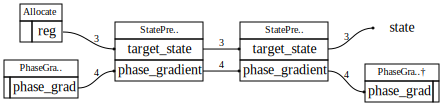

accuracy: 0.9999999999999991

Coefficients in polar form:
  |000> result: 1.0 ∠0.0º
  |001> result: 0.0 ∠0.0º
  |010> result: 0.0 ∠0.0º
  |011> result: 0.0 ∠0.0º
  |100> result: 0.0 ∠0.0º
  |101> result: 0.0 ∠0.0º
  |110> result: 0.0 ∠0.0º
  |111> result: 0.0 ∠0.0º


In [9]:
qsp_adj = StatePreparationViaRotations(
    phase_bitsize=phase_bitsize, state_coefficients=tuple(state_coefs), uncompute=True
)

bb = BloqBuilder()
state = bb.allocate(state_bitsize)
phase_gradient = bb.add(PhaseGradientState(phase_bitsize))
state, phase_gradient = bb.add(
    qsp, target_state=state, phase_gradient=phase_gradient
)
state, phase_gradient = bb.add(
    qsp_adj, target_state=state, phase_gradient=phase_gradient
)
bb.add(PhaseGradientState(bitsize=phase_bitsize).adjoint(), phase_grad=phase_gradient)
circuit = bb.finalize(state=state)

show_bloq(circuit)
coefficients = circuit.tensor_contract()

accuracy = coefficients[0] # <coefficients|0> = coefficients[0]
print(f"accuracy: {abs(accuracy)}\n")

print("Coefficients in polar form:")
# zero out small coefficients
coefficients[np.where(abs(coefficients) < 1e-16)] = 0.0
for i, c in enumerate(coefficients):
    print(f"  |{i:0{state_bitsize}b}> result: {round(abs(c),4)} ∠{round(np.angle(c, deg=True),2)}º")